# CartPole Experiment

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name="gpu")
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import gymnasium as gym
from IPython import display
plt.rcParams['figure.dpi'] = 150

In [7]:
# What do I want to do here?

# Cartpole is an environment provided by OpenAI gym.
# This is one of the basic RL envs - has been described as the "Hello World" of RL 
# The state is defined by the observation - this has cart position, cart velocity, pole angle, and pole
# angular velocity in that order (numbers output from env.reset())
# env.step(action = 0 or 1) gives us observation, reward, done, info, in that order
# reward = +1 for every additional step, including termination step
# More info can be found here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

# I want use a DQN algorithm to train an agent to complete this environment successfully
# I plan on experimenting with different:
# a) neural net architectures
# b) learning rates 
# c) explore / exploit values

In [8]:
class DQNAgent():
    """
    RL agent that utilizes a DQN algorithm to solve the Cartpole environment.
    """
    
    def __init__(self, gamma=0.95, epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.01, tau=0.99):
        """
        Initialize agent.
        
        Arguments:
            gamma (float): Future reward discounting factor
            epsilon (float): Starting value representing percentage of the time that the agent chooses a random action. E.g 0.75 = 75%
            epsilon_decay (float): Epsilon is multiplied by this factor after each training step.
            epsilon_min (float): Minimum value for epsilon.
            tau (float): Rate at which the target-q network is updated.
            
        Returns:
            None
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min 
        self.tau = tau
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4)) #USED TO BE 2.5e-4
        self.target_q = self.make_q_function()
        self.target_q.compile(loss='mse', optimizer='adam')
        self.target_q.set_weights(self.q_function.weights)
        self.max_memory = 10000
    
    
    def find_action(self, state):
        """
        Taking an action according to current policy of the agent. 
        
        Arguments:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
        
        Returns:
            action (int): 0 or 1, corresponding to whether to push the cart left or right.
        """
        
        # If random float is less than epsilon, we choose the action randomly
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, 2)
            
        # Otherwise, choose the action that is the agent's current best guess for max future reward
        else:
            # Find action with best q-value
            # Find q-value estimates for each action using q-function
            q_vals = self.q_function.predict(state[np.newaxis, :], verbose=False)
            # Find best value by taking index of the largest argument
            action = np.argmax(q_vals)
    
        return action
    
    
    def take_step(self, env):
        """
        Take a step in the Cartpole environment with the agent.
        
        Arguments:
            env: Cartpole environment object
        
        Returns:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
            reward (int): +1 if the episode has not yet terminated, 0 otherwise
            done (bool): Whether or not episode has terminated
            action (int): 1 or 0, corresponding to whether the cart was pushed left or right
            info (dict): Empty dictionary
        """
        
        action = self.find_action(self.state)
        new_state, reward, done, info = env.step(action)[:4]
        old_state = self.state
        self.state = new_state
        return old_state, action, reward, new_state, done
    
    
    def make_q_function(self):
        """
        Create a q-function to estimate future reward values for a given state-action pair.
        
        Arguments:
            None
        
        Returns:
            model: Untrained Keras sequential model. 
        """
        
        model = Sequential(
            [
                Dense(128, activation='relu', input_shape=(4,)),
                Dense(64, activation='relu'),
                Dense(2, activation='linear')
            ]
        )
        
        return model
        
    
    def train(self):
        """
        Use memory of experience to train agent using gradient descent.
        
        Arguments:
            None
            
        Returns:
            None
        """
            
        # Define target q = reward + gamma * target q of next state
        future_reward = np.max(self.target_q.predict(self.memory[:, -4:], verbose=False), axis=1)
        future_reward = np.where(self.memory[:, 6], 0, future_reward)
        
        target_vals = self.memory[:, 5] + self.gamma * future_reward
        
        q_vals = self.q_function.predict(self.memory[:, :4], verbose=False)
        
        current_actions = self.memory[:, 4]
        col1 = ((q_vals[:, 0] * current_actions) + ((1 - current_actions) * target_vals)).reshape(q_vals.shape[0], 1)
        col2 = ((q_vals[:, 1] * (1 - current_actions)) + (current_actions * target_vals)).reshape(q_vals.shape[0], 1)
        final_target = np.concatenate((col1, col2), axis=1)
        
        # Train q-function with mse against target-q
        self.q_function.fit(self.memory[:, :4], final_target, shuffle=True, batch_size=64, verbose=False)
        
        # Update target-q to be tau * target q weights + (1 - tau) * q weights
        new_weights = [self.tau * i + (1 - self.tau) * j for i, j in zip(self.target_q.weights, self.q_function.weights)]
        self.target_q.set_weights(new_weights) 
        
        
    def go(self, env, num_rounds=100, train_freq=5):
        """
        Run the agent till termination num_rounds times.
        
        Arguments:
            env: Cartpole environment object
            num_rounds (int): Number of times we want the agent to run until termination.
            train_freq (int): Train the agent after every train_freq rounds.
            
        Returns:
            None
        """
        
        self.memory = np.zeros((1, 11))
        length_lst = []
        
        # Each round is a complete runthrough of the environment until termination
        for i in tqdm(range(num_rounds)):
            
            # Tracking whether or not current iteration has terminated
            complete = False
            
            # Resetting to initial state
            self.state = env.reset()[0]
            
            # Variable to keep track of number of steps taken in each round
            length = 0
            
            while not complete:
                
                old_state, action, reward, new_state, done = self.take_step(env)
                
                # Add data to current iteration memory
                if self.memory.any():
                    curr_data = np.append(np.append(old_state, (action, reward, done)), new_state).reshape(1, 11)
                    self.memory = np.concatenate((self.memory, curr_data), axis=0)
                else: 
                    self.memory = (np.append(np.append(old_state, (action, reward, done)), new_state)).reshape(1, 11)
                
                if len(self.memory) > self.max_memory:
                    idx = np.random.randint(0, self.max_memory, size=self.max_memory) 
                    self.memory = self.memory[idx, :]
                    
                if len(self.memory) > 64:
                    self.train()
                
                if done:
                    complete = True
                    
                length += 1
                
                if length > 550:
                    break

                
             # Update epsilon
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.epsilon_min)
            
            length_lst.append(length)
            
            if np.mean(length_lst[-10:]) >= 475:
                break
            
            if i % 10 == 0:
                print("Episode {} last 10 reward avg: {}, epsilon: {}".format(i, np.mean(length_lst[-10:]), self.epsilon))
                               
        return length_lst


In [9]:
def rolling_average(lengths, window):
    avgs = []
    for i in range(len(lengths)):
        if i < window:
            avgs.append(0)
        else:
            avgs.append(np.mean(lengths[i - window: i]))
    return avgs

In [10]:
agent = DQNAgent()

In [11]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [12]:
lengths = agent.go(env, num_rounds=300)

  0%|▎                                                                                            | 1/300 [00:00<00:30,  9.86it/s]

Episode 0 last 10 reward avg: 40.0, epsilon: 0.891


  4%|███▎                                                                                        | 11/300 [00:07<03:45,  1.28it/s]

Episode 10 last 10 reward avg: 14.4, epsilon: 0.8058044288328449


  7%|██████▍                                                                                     | 21/300 [00:18<04:35,  1.01it/s]

Episode 20 last 10 reward avg: 16.6, epsilon: 0.7287550813991327


 10%|█████████▌                                                                                  | 31/300 [00:36<10:02,  2.24s/it]

Episode 30 last 10 reward avg: 24.4, epsilon: 0.6590730326889578


 14%|████████████▌                                                                               | 41/300 [01:22<32:26,  7.51s/it]

Episode 40 last 10 reward avg: 53.6, epsilon: 0.5960538368855853


 17%|███████████████▋                                                                            | 51/300 [01:55<20:42,  4.99s/it]

Episode 50 last 10 reward avg: 33.2, epsilon: 0.5390604058195451


 20%|██████████████████▋                                                                         | 61/300 [02:40<17:48,  4.47s/it]

Episode 60 last 10 reward avg: 40.7, epsilon: 0.48751656837016827


 24%|█████████████████████▊                                                                      | 71/300 [03:14<11:32,  3.02s/it]

Episode 70 last 10 reward avg: 28.2, epsilon: 0.4409012457037845


 27%|████████████████████████▊                                                                   | 81/300 [04:13<23:29,  6.44s/it]

Episode 80 last 10 reward avg: 43.7, epsilon: 0.39874318346355536


 30%|███████████████████████████▉                                                                | 91/300 [05:27<28:10,  8.09s/it]

Episode 90 last 10 reward avg: 50.7, epsilon: 0.3606161876563865


 34%|██████████████████████████████▋                                                            | 101/300 [06:29<13:37,  4.11s/it]

Episode 100 last 10 reward avg: 38.3, epsilon: 0.3261348160744472


 37%|█████████████████████████████████▋                                                         | 111/300 [07:43<22:29,  7.14s/it]

Episode 110 last 10 reward avg: 42.1, epsilon: 0.2949504816940234


 40%|████████████████████████████████████▋                                                      | 121/300 [10:07<28:41,  9.62s/it]

Episode 120 last 10 reward avg: 75.9, epsilon: 0.26674792865928726


 44%|███████████████████████████████████████▋                                                   | 131/300 [11:05<13:20,  4.74s/it]

Episode 130 last 10 reward avg: 28.2, epsilon: 0.24124204522518672


 47%|██████████████████████████████████████████▊                                                | 141/300 [12:57<33:41, 12.71s/it]

Episode 140 last 10 reward avg: 51.1, epsilon: 0.2181749814401222


 50%|█████████████████████████████████████████████▊                                             | 151/300 [15:33<22:27,  9.05s/it]

Episode 150 last 10 reward avg: 66.7, epsilon: 0.1973135424298251


 54%|████████████████████████████████████████████████▊                                          | 161/300 [19:03<47:12, 20.38s/it]

Episode 160 last 10 reward avg: 81.8, epsilon: 0.178446830930023


 57%|███████████████████████████████████████████████████▊                                       | 171/300 [21:24<32:00, 14.89s/it]

Episode 170 last 10 reward avg: 50.7, epsilon: 0.1613841152352395


 60%|██████████████████████████████████████████████████████▉                                    | 181/300 [24:59<39:08, 19.74s/it]

Episode 180 last 10 reward avg: 72.6, epsilon: 0.14595290100990588


 64%|█████████████████████████████████████████████████████████▉                                 | 191/300 [27:25<34:06, 18.78s/it]

Episode 190 last 10 reward avg: 46.1, epsilon: 0.13199718746889333


 67%|████████████████████████████████████████████████████████████▉                              | 201/300 [33:18<51:44, 31.36s/it]

Episode 200 last 10 reward avg: 105.0, epsilon: 0.1193758902984439


 70%|████████████████████████████████████████████████████████████████                           | 211/300 [40:54<47:11, 31.81s/it]

Episode 210 last 10 reward avg: 130.4, epsilon: 0.1079614153741301


 74%|███████████████████████████████████████████████████████████████████                        | 221/300 [41:57<08:45,  6.65s/it]

Episode 220 last 10 reward avg: 18.1, epsilon: 0.09763836885694321


 77%|██████████████████████████████████████████████████████████████████████                     | 231/300 [44:25<17:04, 14.85s/it]

Episode 230 last 10 reward avg: 42.5, epsilon: 0.08830239062731732


 80%|█████████████████████████████████████████████████████████████████████████                  | 241/300 [49:09<18:33, 18.87s/it]

Episode 240 last 10 reward avg: 78.9, epsilon: 0.07985909926377122


 84%|████████████████████████████████████████████████████████████████████████████▏              | 251/300 [54:27<33:22, 40.87s/it]

Episode 250 last 10 reward avg: 89.6, epsilon: 0.07222313790050347


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 261/300 [1:00:51<21:30, 33.08s/it]

Episode 260 last 10 reward avg: 108.0, epsilon: 0.06531731131810435


 90%|████████████████████████████████████████████████████████████████████████████████▍        | 271/300 [1:07:25<23:12, 48.02s/it]

Episode 270 last 10 reward avg: 112.1, epsilon: 0.05907180554386329


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 281/300 [1:23:20<32:17, 101.95s/it]

Episode 280 last 10 reward avg: 266.5, epsilon: 0.05342348207227568


 97%|██████████████████████████████████████████████████████████████████████████████████████▎  | 291/300 [1:30:46<05:16, 35.15s/it]

Episode 290 last 10 reward avg: 123.2, epsilon: 0.04831523957072034


100%|█████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:34:25<00:00, 18.88s/it]


Text(0, 0.5, 'Episode length')

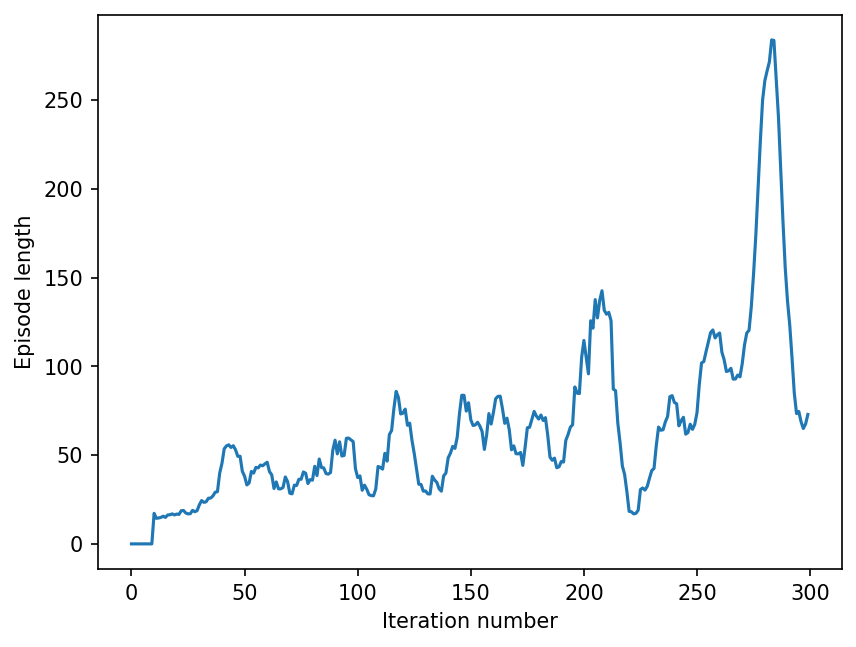

In [13]:
iters = np.arange(300)
plt.plot(iters, rolling_average(lengths, 10))
plt.xlabel("Iteration number")
plt.ylabel("Episode length")

In [14]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]
agent_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    ep_length = 0
    
    done = False
    
    while not done:
        _, _, _, _, done = agent.take_step(env)
        ep_length += 1
    
    agent_lengths.append(ep_length)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:28<00:00,  2.69s/it]


In [15]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
random_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    done = False
    
    ep_length = 0
    
    while not done:
        action = np.random.randint(0, 2)
        _, _, done, _, _ = env.step(action)
        ep_length += 1
    
    random_lengths.append(ep_length)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6375.39it/s]


In [16]:
np.mean(agent_lengths)

168.83

In [17]:
np.mean(random_lengths)

22.36

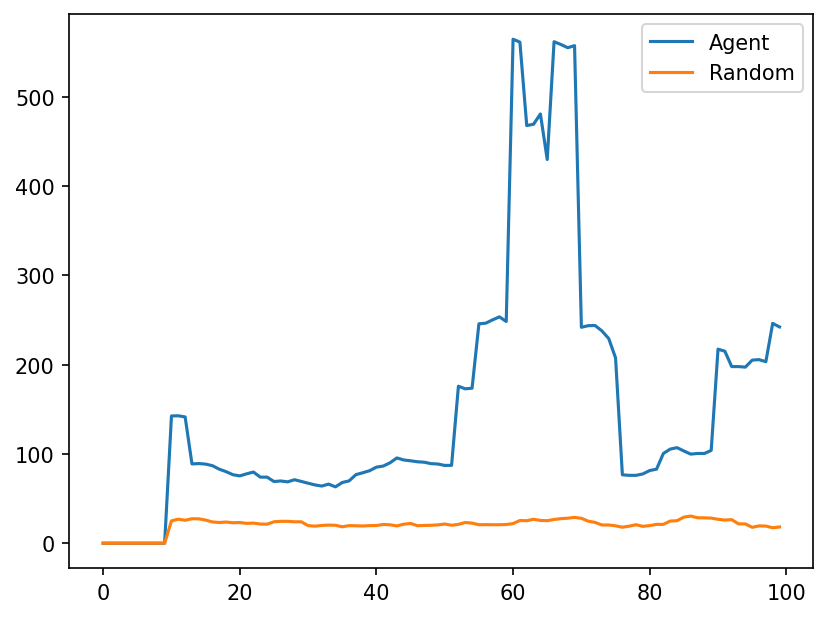

In [18]:
plt.plot(np.arange(100), rolling_average(agent_lengths, 10), label='Agent')
plt.plot(np.arange(100), rolling_average(random_lengths, 10 ), label='Random')
plt.legend()

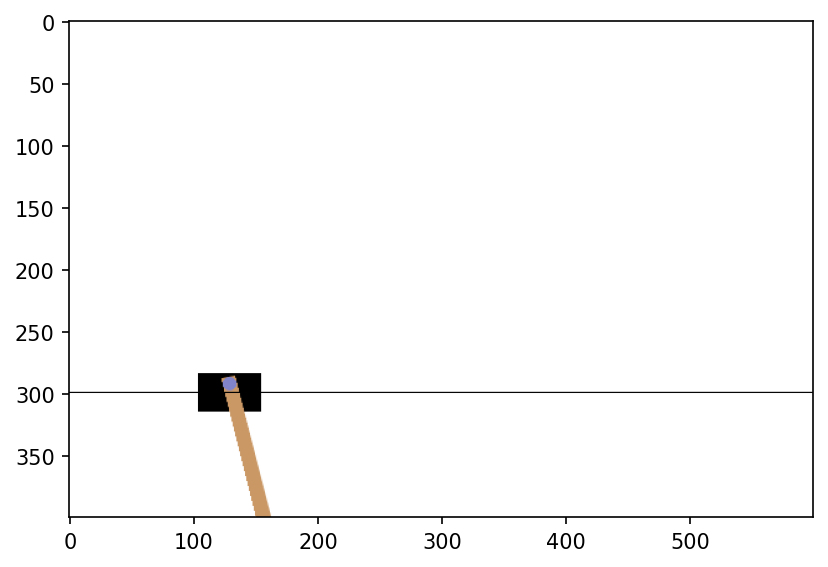

In [50]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]

for i in range(50):
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
#     env.step(env.action_space.sample()) # take a random action
    env.step(agent.find_action(agent.state))
    agent.state = np.array(env.state)
    
env.close()